In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from GenerateInput import generate_input
from models import GameOfLifeModel, ContinuousGameOfLife3x3
from CostumisedLayers import CyclicPadding2D

Visualizing the continuous model for the 3x3 game of life.  It uses two variables:
- the state of the cell
- the sum of the states of the neighbouring cells

and it does exactly what is shown in the figure below

In [51]:
around_cell_possible_values = np.arange(8, -0.00001, -0.02)
cell_possible_values = np.arange(0,1.00001,0.01)

around_cell = [list(around_cell_possible_values)]*len(cell_possible_values)
cell = [list(cell_possible_values)] * len(around_cell_possible_values)

around_cell = np.array(around_cell)
around_cell = np.transpose(around_cell)
cell = np.array(cell)

In [126]:
around_cell = tf.constant(around_cell)
cell = tf.constant(cell)

almost_zero = 0.1
border = 0.4

x1 = tf.math.maximum(((8-around_cell)/(8-3))*almost_zero, (3+border-around_cell)/border )
x2 = tf.math.maximum((around_cell-(3-border))/border, around_cell*almost_zero/3 )

x3 = tf.math.maximum((cell-(1-border))/border, cell*almost_zero)

x4 = tf.math.maximum((around_cell-(2-border))/border, around_cell*almost_zero/2 )

x12 = tf.math.minimum(x1,x2)
x34 = tf.math.minimum(x3,x4)

x5 = tf.math.minimum(x1,x34)
xx = tf.math.maximum(x12,x5)



The colour indicates the status of the cell for the next step


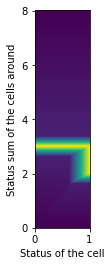

In [127]:
plt.figure(figsize=(2,4))
plt.imshow(xx, vmin=0, vmax=1)

plt.yticks([401,301, 201, 101, 0], [0,2,4,6, 8])
plt.xticks([0,101], [0,1])
plt.xlabel('Status of the cell')
plt.ylabel('Status sum of the cells around')

print('The colour indicates the status of the cell for the next step')

In [5]:
# Initializing the general model, with the 3x3 model created above
class ContinuousGameOfLife(tf.keras.layers.Layer):
    
    def __init__(self, ):
        super(ContinuousGameOfLife, self).__init__()
        self.flat = tf.keras.layers.Flatten()
        self.add_padding = CyclicPadding2D()

    def build(self, input_shape):
        self.k1 = tf.constant([[1,1,1],[1,0,1],[1,1,1]], dtype='float32')
        self.k1 = tf.reshape(self.k1, shape=(3,3,1,1))
        self.k2 = tf.constant([[0,0,0],[0,1,0],[0,0,0]], dtype='float32')
        self.k2 = tf.reshape(self.k2, shape=(3,3,1,1))
        super(ContinuousGameOfLife, self).build(input_shape)
        
    def call(self, inputs):
        batch_size, d1, d2 = inputs.shape
        x = self.add_padding(inputs)
        x = tf.reshape(x, shape=(batch_size, d1+2, d2+2, 1))
        cell = tf.nn.conv2d(x, filters=self.k2, strides=1, padding='VALID')
        around_cell = tf.nn.conv2d(x, filters=self.k1, strides=1, padding='VALID')

        x1 = tf.math.maximum(4-around_cell,0)
        x2 = tf.math.maximum((around_cell + cell)-2,0)
        x3 = tf.math.minimum(x1, x2)
        x4 = tf.math.minimum(x3,1)

        return tf.reshape(x4, shape=(batch_size,d1,d2))


In [6]:
game = ContinuousGameOfLife()

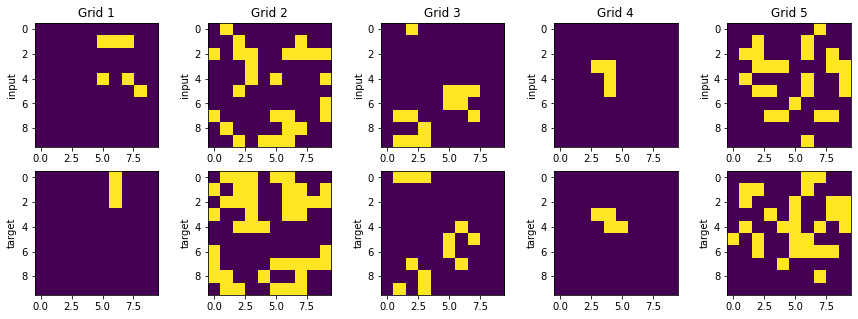

In [7]:
# generating some inputs and targets for the general mode

x, y = generate_input(trials=8, grid_shape=(10,10),steps_before_generating_output=2)


plt.figure(figsize=(3*len(x), 5))
for i in range(len(x)):
    plt.subplot(2, len(x), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(x[i])
    plt.ylabel('input')
    plt.subplot(2, len(x), len(x)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')    

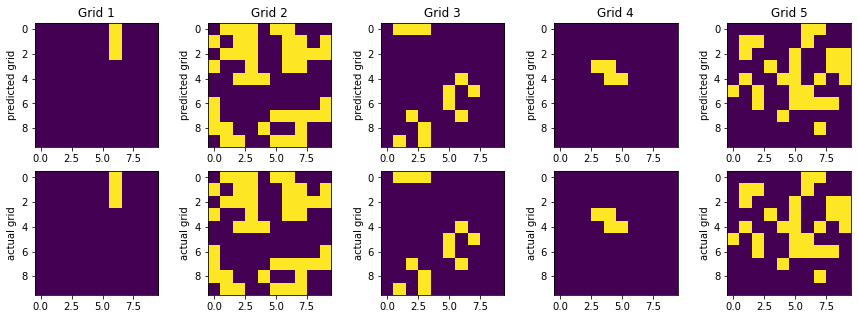

In [8]:
# checking that the general model actually works
y_pred = game(x)

plt.figure(figsize=(3*len(x), 5))
for i in range(len(y)):
    plt.subplot(2, len(y), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(y_pred[i])
    plt.ylabel('predicted grid')
    plt.subplot(2, len(y), len(y)+i+1)
    plt.imshow(y[i])
    plt.ylabel('actual grid')

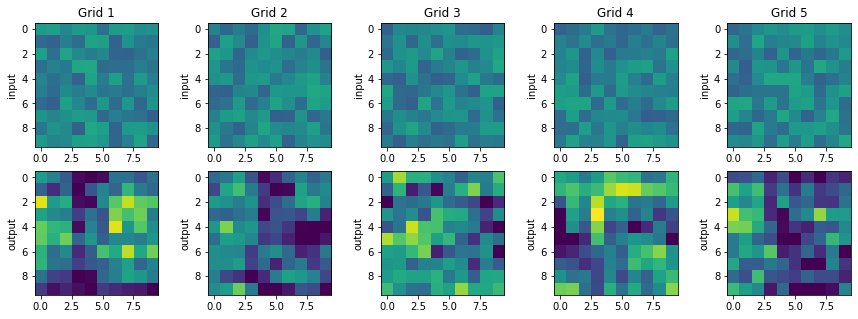

In [9]:
n = len(y)

input_img = tf.Variable(tf.random.uniform(shape=(n,10, 10), minval=0.3, maxval=0.6), name='input_image', trainable=True, validate_shape=True)

output_img = game(input_img)


plt.figure(figsize=(3*n, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(input_img[i], vmin=0, vmax=1)
    plt.ylabel('input')
    plt.subplot(2, n, n+i+1)
    plt.imshow(output_img[i], vmin=0, vmax=1)
    plt.ylabel('output')


In [10]:
class ContinuousReverseGame(tf.keras.models.Model):
    
    def __init__(self, min_v, max_v, grid_len):
        super(ContinuousReverseGame, self).__init__()
        self.add_padding = CyclicPadding2D()
        self.min_v = min_v
        self.max_v = max_v
        self.l = grid_len
        self.k1 = tf.constant([[1,1,1],[1,0,1],[1,1,1]], dtype='float32')
        self.k1 = tf.reshape(self.k1, shape=(3,3,1,1))
        self.k2 = tf.constant([[0,0,0],[0,1,0],[0,0,0]], dtype='float32')
        self.k2 = tf.reshape(self.k2, shape=(3,3,1,1))
        # self.input_img = tf.Variable(tf.random.uniform(shape=(1,grid_len, grid_len), minval=self.min_v, maxval=self.max_v), name='input_image', trainable=True, validate_shape=True)

    def build(self, input_shape):
        self.input_img = self.add_weight(name="W", shape=(1,self.l,self.l), initializer= tf.keras.initializers.RandomUniform(minval=0.3, maxval=0.5), trainable=True)
        
    def call(self, inputs):
        print(inputs.shape)
        x = tf.math.multiply(inputs, self.input_img)
        print(x.shape)
        x = self.add_padding(x)
        x = tf.reshape(x, shape=(-1, self.l+2, self.l+2, 1))
        cell = tf.nn.conv2d(x, filters=self.k2, strides=1, padding='VALID')
        around_cell = tf.nn.conv2d(x, filters=self.k1, strides=1, padding='VALID')

        x1 = tf.math.maximum(4-around_cell,0)
        x2 = tf.math.maximum((around_cell + cell)-2,0)
        x3 = tf.math.minimum(x1, x2)
        x4 = tf.math.minimum(x3,1)

        return tf.reshape(x4, shape=(-1,self.l,self.l))


In [11]:
reverse_game = ContinuousReverseGame(min_v=0.3, max_v=0.6, grid_len=10) 
reverse_game.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
inputs = tf.keras.layers.Input(shape=(10,10), batch_size=5)
# reverse_game(inputs)
# print('here')
# print(input_img[:1].shape)
# y_pred = reverse_game.predict(input_img, batch_size=1)


(5, 10, 10)
(5, 10, 10)


NotImplementedError: in converted code:

    <ipython-input-10-ad84f97fe043>:22 call  *
        x = self.add_padding(x)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:842 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    c:\Users\Lisa\Lisa\Progetti Python and Research\Game of Life\CostumisedLayers.py:37 call  *
        return tf.constant(self.grid.numpy())
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:579 numpy
        "numpy() is only available when eager execution is enabled.")

    NotImplementedError: numpy() is only available when eager execution is enabled.


In [12]:
reverse_game.summary()

Model: "continuous_reverse_game"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cyclic_padding2d_1 (CyclicPa multiple                  720       
Total params: 820
Trainable params: 100
Non-trainable params: 720
_________________________________________________________________


In [45]:
reverse_game.fit(x[:3], y[:3])

In [13]:
W =reverse_game.get_weights()
W

[array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,